<a href="https://colab.research.google.com/github/ericbill21/siemens/blob/master/Siemens_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Imports
%tensorflow_version 2.x
from IPython.display import clear_output
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import sys
import gc
import logging
import time
tf.get_logger().setLevel(logging.ERROR)

#time prediciton
prev_time = 0

#Constants
colors = {0 : 'green', 1 : 'red', 'green' : 0, 'red' : 1}
sources = {'A' : 'https://drive.google.com/file/d/1hAzAKZNpmSclSI7HnV_cRjpMS4Kh5r1q/view?usp=sharing', 'B' : 'https://drive.google.com/file/d/12VlecL-5iYs-BFpnTOba1x65jWofBX1P/view?usp=sharing', 'C' : 'https://drive.google.com/file/d/1-Z0RuJIi1cZcqrrmV6TqT0O1PwI2OiBY/view?usp=sharing'}
source_size = {'A': 1000,'B' : 5000, 'C' : 50000}

In [ ]:
#Configuration
plt.style.use('seaborn')

tf.random.set_seed(31415)

dataSetName = 'B'

#Examlpe sets
subsetA = [47, 847, 993, 55, 102, 572, 430, 115, 842, 72, 770, 107, 78, 834, 593, 43, 234, 709, 210, 378]
subsetB = [606, 2663, 1809, 2145, 4539, 3333, 3562, 2262, 512, 2046, 1541, 909, 286, 4815, 3663, 1742, 2822, 2756, 2937, 3080, 3845, 3949, 2506, 3984, 2803, 2067]
subsetC = [32088, 33534, 39634, 40177, 25142, 752, 41771, 11793, 16415, 3811, 2096, 35902, 42221, 19594, 25109, 40476, 25162, 41150, 34610, 28329, 46339, 43149, 44441, 25720, 38747, 49497, 12708, 23920, 2280, 17946]

sampleSet_indices = subsetB

weight = 0.3

In [ ]:
#@title Functions

def getDataSet(dataSetName):
  path = 'https://drive.google.com/uc?export=download&id='+sources[dataSetName].split('/')[-2]
  return pd.read_excel(path)


#Plots the given dataSet in the rigth colors
def makePlot(t_data = None, marker = [], marker_false = []):

  if t_data == None:
    t_data = getDataSet(dataSetName) 
  
  data_x1 = np.array(t_data.pop('x_i1'))
  data_x2 = np.array(t_data.pop('x_i2'))
  data_l = np.array(t_data.pop('l_i'))

  fig, ax = plt.subplots()
  
  for i in range(2):
    x_1 = []
    x_2 = []
    for j in range(np.size(data_x1)):
      if data_l[j] == i:
        x_1.append(data_x1[j])
        x_2.append(data_x2[j])
    ax.scatter(x_1, x_2, c = colors[i])

  for i in marker:
    ax.scatter(i[0],i[1],marker = "x", c = 'black')

  for i in marker_false:
    ax.scatter(i[0],i[1],marker = "*", c = 'black')

  plt.xlabel('x_i1')
  plt.ylabel('x_i2')
  plt.title(f'DataSet {dataSetName}')
  plt.axis('scaled')
  plt.show()


# Prepares a subset of the dataSet for validation
def popPredictionPoints(dataSet, sampleSet_indices):
  sampleSet_x1_x2 = []
  sampleSet_li = []

  for i in sampleSet_indices:
    sampleSet_x1_x2.append([dataSet['x_i1'].loc[i], dataSet['x_i2'].loc[i]])
    sampleSet_li.append([dataSet['l_i'].loc[i]])
  
  # Saving the testing points
  prediction_point = tf.constant(sampleSet_x1_x2, tf.float32)
  prediciton_label = tf.constant(sampleSet_li, tf.float32)

  #Removing the testing point
  dataSet.drop(index=sampleSet_indices, inplace=True)
  dataSet.reset_index(inplace=True)

  return (prediction_point, prediciton_label)



# Print iterations progress
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    sys.stdout.write(f'\r{prefix} |{bar}| {percent}% ETA: {round(timeCalc()*(total-iteration), 2)} minutes {suffix}')
    sys.stdout.flush()
    # Print New Line on Complete
    if iteration == total:
      global prev_time
      prev_time = 0
      sys.stdout.write('\r')
      sys.stdout.flush()


def makeCertaintiyMap(model, accuracy = 100, specific_color = None):
  accuracy_map = np.zeros((accuracy, accuracy))

  for i in range(accuracy):
    tensor = tf.constant([[j/accuracy, i/accuracy] for j in range(accuracy)], tf.float32)
    result = model.predict(tensor)

    if specific_color != None:
      accuracy_map[i] = result[:, specific_color]
    else:
      result = result.max(axis=1) #Getting each max value
      if max(result) != min(result):
        normalized = (result-min(result))/(max(result)-min(result))
        accuracy_map[i] = normalized
      else: 
        accuracy_map[i] = result
      
    
    printProgressBar(i, accuracy-1)


  plt.imshow(accuracy_map, origin='lower', cmap='tab20b', vmin=0, vmax=1)
  plt.colorbar()
  plt.show()
  return accuracy_map




def plotAllWeightCombinations(model, accuracy = 100):
  print('Chosen Subset:')
  makePlot(marker=prediction_points.numpy())

  result_x = np.zeros(accuracy+1)
  result_y = np.zeros(accuracy+1)

  printProgressBar(0, accuracy,prefix='Progress', suffix='ETA: ')

  # Iterating over every weigth
  for i in range(accuracy+1):
    keras.backend.clear_session()
    prevTime = time.time()

    weight = i/accuracy #Selecting a value between 0 and 1 with steps of 1/accuracy

    model.compile(optimizer='adam',loss=construct_custom_weigthing_loss(weight) ,metrics=['accuracy'])
    model.fit(training_points, training_labels, batch_size=32, epochs=10, shuffle=True, verbose=0)
    
    #Saving results
    result_x[i] = weight
    result_y[i] = model.evaluate(prediction_points, prediction_labels, verbose=0)[0]

    #Printing progress
    printProgressBar(i+1, accuracy+1,prefix='Progress')

  #Presenting the results
  print('\nThe loss:')
  plt.plot(result_x, result_y)

  return result_y


def timeCalc():
  global prev_time
  if prev_time == 0:
    prev_time = time.time()
    return 0
  
  res = (time.time() - prev_time) / 60
  prev_time = time.time()
  return res


def plotHistory(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()


def showPredicitons(model, prediction_points, prediction_labels):
  prediction = model.predict(prediction_points)

  points = prediction_points.numpy()
  labels = prediction_labels.numpy()[:, 0].astype(int)

  correct_indices = np.where((labels == np.argmax(prediction, axis=1)) == True)
  wrong_indices = np.where((labels == np.argmax(prediction, axis=1)) == False)

  number_of_points = np.bincount(np.argmax(prediction, axis=1))

  print(f'Predictions for green: {number_of_points[0]} / {len(labels)}')
  print(f'Predictions for red: {number_of_points[1]} / {len(labels)}')
  print(f'The algorithm predicted {np.bincount(labels == np.argmax(prediction, axis=1))[0]} times wrong')
  makePlot(marker=points[correct_indices], marker_false=points[wrong_indices])
  print(f' \'*\' stands for wrong predicted')

  return prediction

In [ ]:
#Preparing data
dataSet = getDataSet(dataSetName)
dataSet.pop('Unnamed: 0') #Removing unnessary column

prediction_points, prediction_labels = popPredictionPoints(dataSet=dataSet, sampleSet_indices=sampleSet_indices)

#Artificially balancing the dataSet
number_of_green_points = list(dataSet['l_i']).count(colors['green'])
number_of_red_points = list(dataSet['l_i']).count(colors['red'])

if number_of_red_points / source_size[dataSetName] <= 0.5:
  amount = int((0.5 - number_of_red_points / source_size[dataSetName]) * source_size[dataSetName])
  red_points = dataSet.loc[dataSet['l_i'] == 1] #Getting all red points
  choosen_points = red_points.sample(amount, replace=True) #Selecting a random subset of red points
  dataSet = dataSet.append(choosen_points, ignore_index=True) #appending the subset

if number_of_green_points / source_size[dataSetName] <= 0.5:
  amount = int((0.5 - number_of_green_points / source_size[dataSetName]) * source_size[dataSetName])
  green_points = dataSet.loc[dataSet['l_i'] == 0] #Getting all green points
  choosen_points = green_points.sample(amount, replace=True) #Selecting a random subset of green points
  dataSet = dataSet.append(choosen_points, ignore_index=True) #appending green subset

if 'index' in dataSet.columns:
  dataSet.pop('index') #removing old indices
  print(f'Artificially exended by {dataSet["x_i1"].size - source_size[dataSetName] + len(sampleSet_indices)} points')
  print(f'Relation is now: {dataSet.loc[dataSet["l_i"] == 0].shape[0]} green  : {dataSet.loc[dataSet["l_i"] == 1].shape[0]} red ')

#Creating tensors
training_labels = tf.constant(dataSet.pop('l_i'), tf.float32)
training_points = tf.constant(dataSet, tf.float32)

Artificially exended by 140 points
Relation is now: 2500 green  : 2614 red 


In [ ]:
def construct_custom_weigthing_loss(weight):

  def custom_weigthing_loss(y_true,y_pred):
    length = tf.shape(y_true)[0]

    #Creating a vector with all values set to the weight: [0.3, 0.3, ... 0.3]
    error = tf.multiply(tf.constant(weight, tf.float32), tf.ones(length)) 

    #Setting every entry to 0 if the corresponding entry in y_true is 1
    error = tf.where(tf.equal(y_true[:, 0], tf.zeros(length)), error, tf.zeros(length))

    #Setting every entry to 0 if the algorithm predicted 0
    error = tf.where(tf.greater(y_pred[:, 0], y_pred[:, 1]), tf.zeros(length), error)

    #Transforms the vector from [0, 0, 0.3, ... 0,3] to [[0, -0], [0, -0], [0.3, -0.3], ... [0.3, -0.3]]
    error = tf.stack([error, tf.multiply(tf.constant(-1, tf.float32), error)], 1)

    #Adding the artificial loss
    y_pred = y_pred + error

    #Eliminating values > 1 or < 0
    y_pred0 = tf.where(tf.greater(y_pred[:, 0], tf.ones(length)), tf.ones(length), y_pred[:, 0])
    y_pred1 = tf.where(tf.greater(y_pred[:, 1], tf.zeros(length)), y_pred[:, 1], tf.zeros(length))
    y_pred = tf.stack([y_pred0, y_pred1], axis=1)


    loss = keras.losses.sparse_categorical_crossentropy(y_pred=y_pred, y_true=y_true)
    return loss
  
  return custom_weigthing_loss

In [ ]:
model = keras.Sequential([
           keras.layers.Flatten(input_shape=(2,)),      #input layer: 2 neurons
           keras.layers.Dense(100,activation='relu'), 
           keras.layers.Dense(70,activation='relu'), 
           keras.layers.Dense(50,activation='relu'),       
           keras.layers.Dense(10,activation='relu'),
           keras.layers.Dense(2,activation='softmax')   #output layer: 2 neurons              
])


model.compile(optimizer='adam',loss=construct_custom_weigthing_loss(weight) ,metrics=['accuracy'])

validation_set = tf.concat([prediction_points, prediction_labels], axis=1)

#history = model.fit(training_points, training_labels, batch_size=32, epochs=5, shuffle=True, )

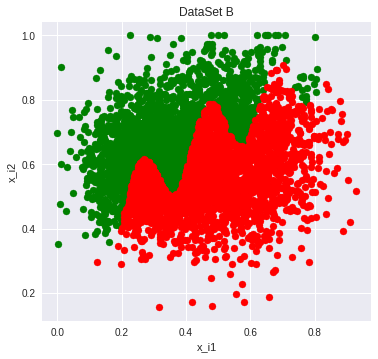

In [ ]:
y = makePlot()

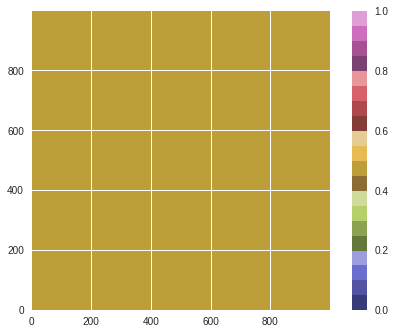

In [ ]:
z = makeCertaintiyMap(model, accuracy=1000, specific_color=0)

Epochs: 0


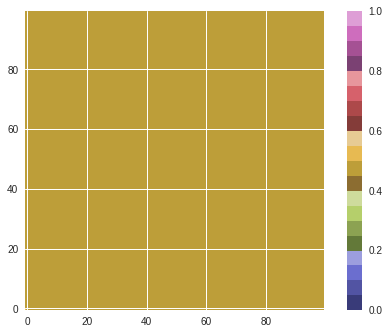

Epochs: 40


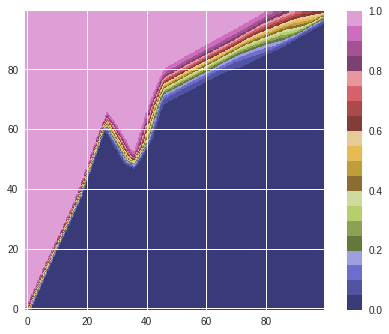

Epochs: 80


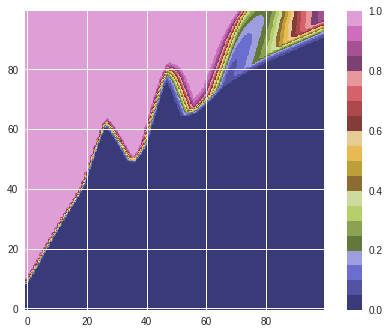

Epochs: 120


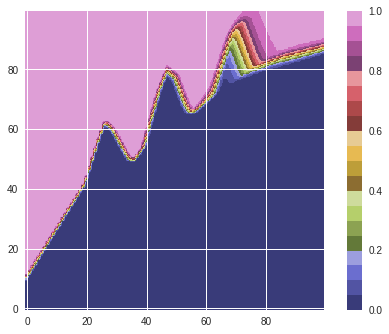

Epochs: 160


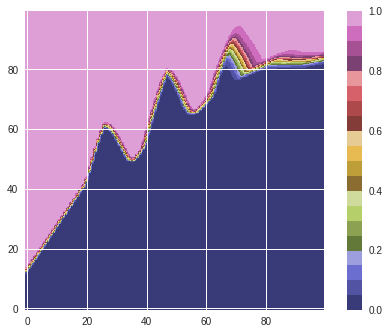

Epochs: 200


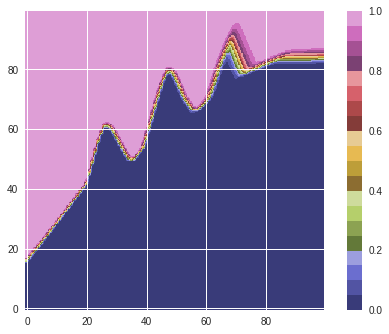

Epochs: 240


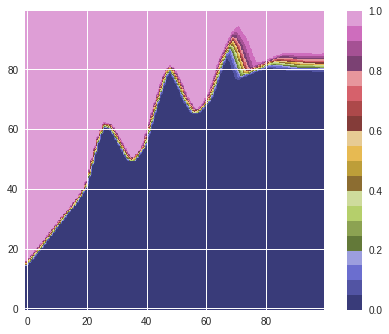

Epochs: 280


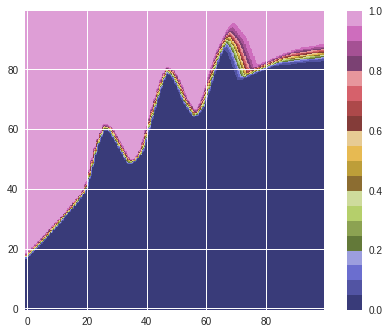

Epochs: 320


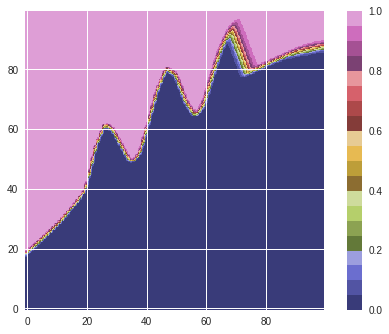

Epochs: 360


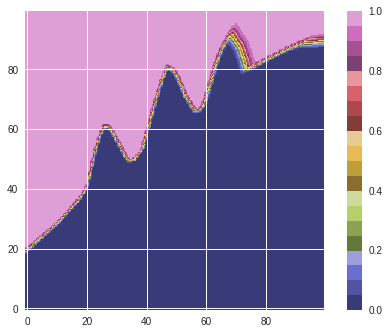

In [ ]:
for i in range(10):
  print(f'Epochs: {i*40}')
  makeCertaintiyMap(model, accuracy=100, specific_color=0)

  model.fit(training_points, training_labels, batch_size=32, epochs=40, shuffle=True, verbose=0)

Epochs: 0


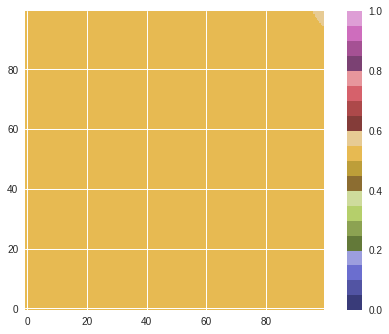

Epochs: 40


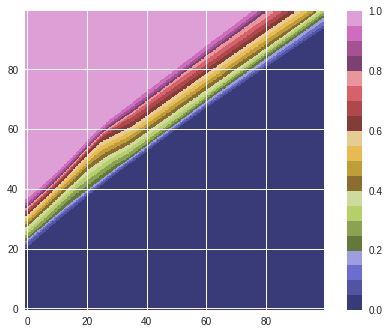

Epochs: 80


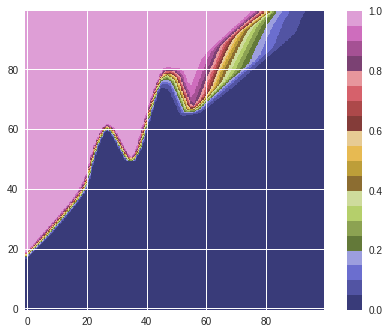

Epochs: 120


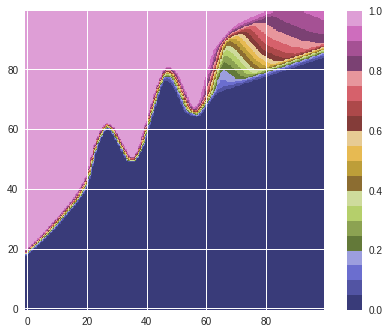

Epochs: 160


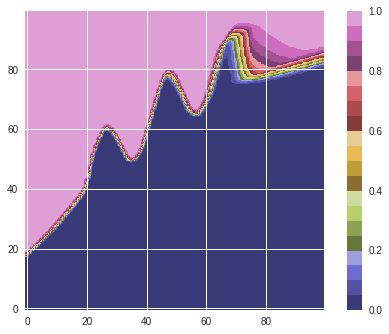

Epochs: 200


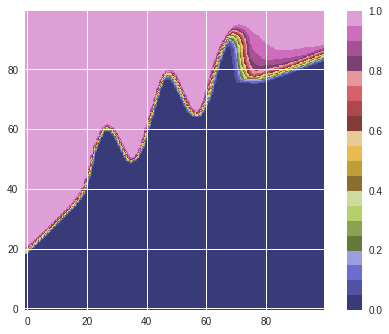

Epochs: 240


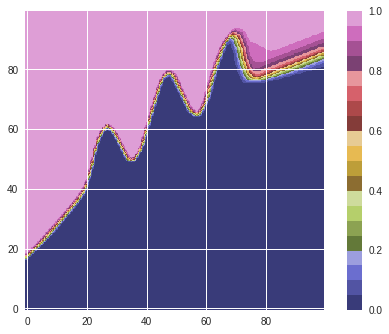

Epochs: 280


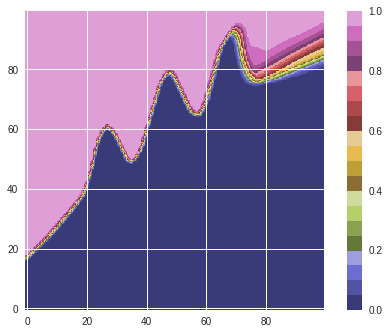

Epochs: 320


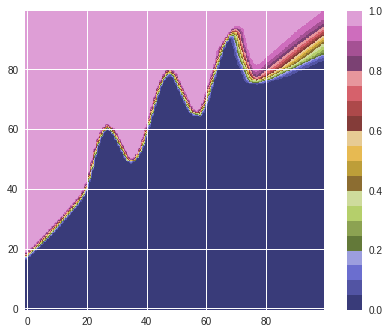

Epochs: 360


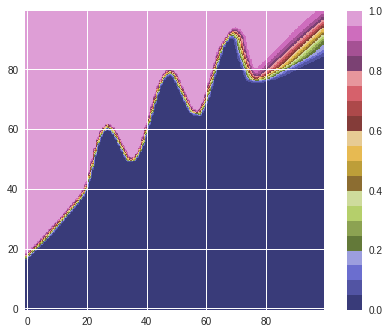

In [ ]:
model = keras.Sequential([
           keras.layers.Flatten(input_shape=(2,)),      #input layer: 2 neurons
           keras.layers.Dense(100,activation='relu'), 
           keras.layers.Dense(70,activation='relu'), 
           keras.layers.Dense(50,activation='relu'),       
           keras.layers.Dense(10,activation='relu'),
           keras.layers.Dense(2,activation='softmax')   #output layer: 2 neurons              
])
model.compile(optimizer='adam',loss=construct_custom_weigthing_loss(0) ,metrics=['accuracy'])
for i in range(10):
  print(f'Epochs: {i*40}')
  makeCertaintiyMap(model, accuracy=100, specific_color=0)
  model.fit(training_points, training_labels, batch_size=32, epochs=40, shuffle=True, verbose=0)